In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from encoding_information.datasets import BSCCMDataset, MNISTDataset
import jax.numpy as np

from cleanplots import *
from tqdm import tqdm

2024-10-02 11:33:43.910250: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 11:33:47.072785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-02 11:33:47.073051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-02 11:33:47.073065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# Process hi res images

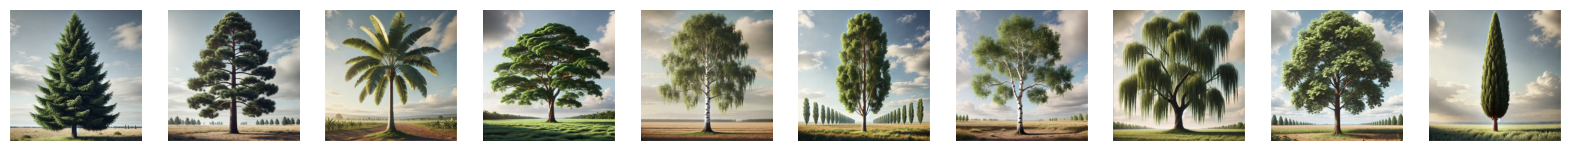

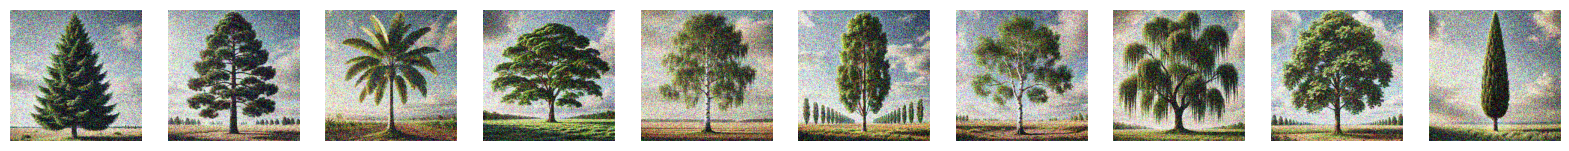

In [12]:
shape = (220, 220)
sigma = 50

# load all png files in '/home/your_username/data/trees/high_res' into numpy arrays
from PIL import Image
import os
import numpy as np

path = '/home/your_username/data/trees/high_res/'
images = []
for name in os.listdir(path):
    img = Image.open(path + name)
    img = np.array(img)
    images.append(img)

# crop to largest square centered in the image
for i, img in enumerate(images):
    h, w = img.shape[:2]
    if h > w:
        diff = h - w
        img = img[:, diff//2:diff//2 + w]
    elif w > h:
        diff = w - h
        img = img[diff//2:diff//2 + h, :]
    images[i] = img

# resize to 128 x 128 numpy arrays
images = np.array([np.array(Image.fromarray(img).resize(shape)) for img in images])

# plot some
from cleanplots import *
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for ax, img in zip(axs, images):
    ax.imshow(img)
    ax.axis('off')

from encoding_information import add_noise
# add noise to images
noisy_images = np.array([add_noise(img, gaussian_sigma=sigma) for img in images])
# clip to 0 255
noisy_images = np.clip(noisy_images, 0, 255) / 255

# plot some
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for ax, img in zip(axs, noisy_images):
    ax.imshow(img)
    ax.axis('off')

# save all in /home/your_username/data/trees/low_res_noisy
save_path = f'/home/your_username/data/trees/low_res_noisy_{shape}_{sigma}/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    # clear the directory
    # for file in os.listdir(save_path):
    #     os.remove(os.path.join(save_path, file))

for i, img in enumerate(noisy_images):
    img = Image.fromarray((img * 255).astype(np.uint8))
    img.save(os.path.join(save_path, f'noisy_{i}.png'))

# Load downsamples/noisy images

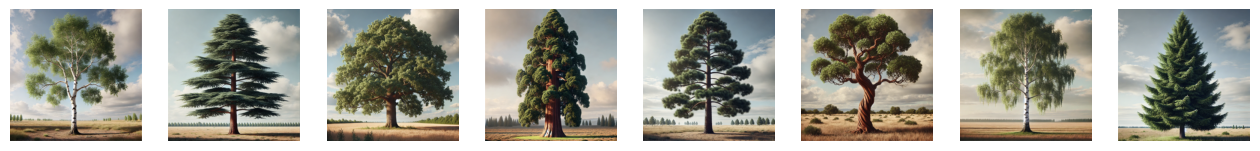

In [2]:
shape = (220, 220)
sigma = 0


from PIL import Image

path = f'/home/your_username/data/trees/low_res_noisy_{shape}_{sigma}/'

images = []
for name in os.listdir(path):
    img = Image.open(path + name)
    img = np.array(img)
    images.append(img)

# plot some
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
for ax, img in zip(axs, images):
    ax.imshow(img)
    ax.axis('off')

images = np.array(images)

In [34]:
from encoding_information import extract_patches

patch_size = 64
num_patches = 12000

patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=True).astype(np.float32)

100%|██████████| 12000/12000 [00:37<00:00, 316.09it/s]


In [5]:
patches = images[:, ::3, ::3]

In [6]:
from encoding_information.models import PixelCNN, FullGaussianProcess, StationaryGaussianProcess 

num_samples = 8

gp = FullGaussianProcess(patches.astype(float))
gp_samples = gp.generate_samples(num_samples=num_samples)


/2tb_nvme/your_username/GitRepos/EncodingInformation/src/encoding_information/models/gaussian_process.py:695: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.001
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.01


/2tb_nvme/your_username/GitRepos/EncodingInformation/src/encoding_information/models/gaussian_process.py:695: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.1


/2tb_nvme/your_username/GitRepos/EncodingInformation/src/encoding_information/models/gaussian_process.py:695: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.1
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 1.0


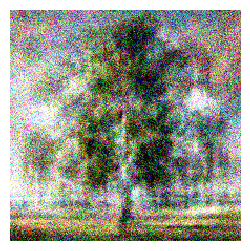

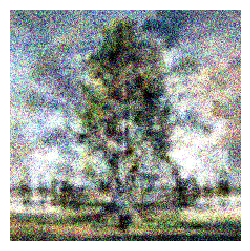

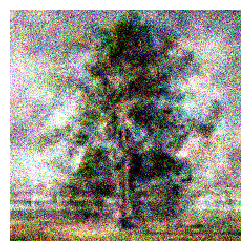

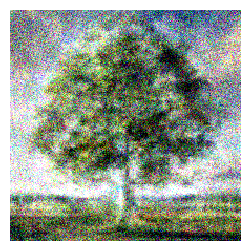

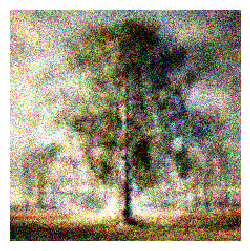

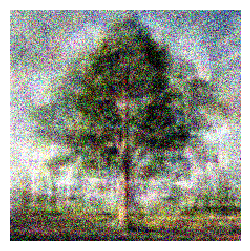

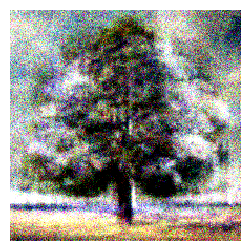

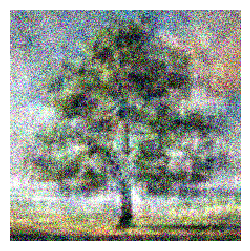

In [11]:
smooth_sigma = 1
noise_sigma = 50
upsample_size = shape

from skimage.transform import resize
from scipy.ndimage import median_filter, gaussian_filter
from encoding_information import add_noise

upsampled_gp_samples = np.array([resize(sample, upsample_size) for sample in gp_samples])


noisy_gp_samples = add_noise(upsampled_gp_samples, gaussian_sigma=noise_sigma)
noisy_gp_samples = np.clip(noisy_gp_samples, 0, 255) / 255

for i, sample in enumerate(noisy_gp_samples):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(sample, interpolation='nearest')
    ax.axis('off')
    # use pillow to save as png
    Image.fromarray((np.array(sample) * 255).astype(np.uint8)).save(f'/home/your_username/data/trees/tree_samples/full_gaussian_sample_smoothed_noised_{i}.png')


# Dots that jump around samples from Gaussian GIF

In [3]:


from PIL import Image, ImageDraw
import numpy as np
import os

def create_gaussian_dot_animation(
    num_frames=30,
    image_size=(500, 500),
    dot_radius=60,
    output_folder='/home/your_username/figures/black_dot/',
    output_format='PNG'
):
    """
    Generates frames of a black dot moving according to a 2D Gaussian distribution.

    Parameters:
    - num_frames (int): Number of frames to generate.
    - image_size (tuple): Size of the image (width, height).
    - dot_radius (int): Radius of the black dot.
    - output_folder (str): Folder to save the frames.
    - output_format (str): Image format to save frames ('PNG' recommended for transparency).
    """

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Parameters for the Gaussian distribution
    mean_x = image_size[0] / 2
    mean_y = image_size[1] / 2
    std_dev_x = image_size[0] / 6  # Adjust as needed
    std_dev_y = image_size[1] / 6  # Adjust as needed

    for i in range(num_frames):
        # Generate random position according to 2D Gaussian distribution
        x = np.random.normal(loc=mean_x, scale=std_dev_x)
        y = np.random.normal(loc=mean_y, scale=std_dev_y)

        # Ensure the dot stays within the image boundaries
        x = max(dot_radius, min(image_size[0] - dot_radius, x))
        y = max(dot_radius, min(image_size[1] - dot_radius, y))

        # Create a transparent image
        frame = Image.new('RGBA', image_size, (255, 255, 255, 0))
        draw = ImageDraw.Draw(frame)

        # Draw the black circular dot
        left_up_point = (x - dot_radius, y - dot_radius)
        right_down_point = (x + dot_radius, y + dot_radius)
        draw.ellipse([left_up_point, right_down_point], fill='#5A00A0')

        # Save the frame
        frame.save(
            os.path.join(output_folder, f'frame_{i:03d}.{output_format.lower()}'),
            format=output_format
        )

# Example usage
create_gaussian_dot_animation()


In [4]:
!convert -delay 3.33 -loop 0 -dispose background /home/your_username/figures/black_dot/frame_*.png -coalesce -layers optimize /home/your_username/figures/black_dot/animated_dot.gif


# Single tree image noisy

In [27]:
shape = (128, 128)
sigma = 100

# load tree1 high res
tree1 = Image.open('/home/your_username/data/trees/high_res/tree1.png')
tree1 = np.array(tree1)

# resize
tree1 = np.array(Image.fromarray(tree1).resize(shape))

# make 30 noisy versions
noisy_tree1 = np.array([add_noise(tree1, gaussian_sigma=sigma) for _ in range(30)])
# clip to 0 255
noisy_tree1 = np.clip(noisy_tree1, 0, 255) / 255

# save to uncompressed pngs
for i, img in enumerate(noisy_tree1):
    img = Image.fromarray((img * 255).astype(np.uint8))
    img.save(f'/home/your_username/data/trees/noisy_tree_movie/{i}.png')

In [28]:
# convert like this one
# !rm /home/your_username/figures/trees_changing_noise/noisy_encoder_comparison.mp4
# !ffmpeg -y -framerate 30 -i /home/your_username/figures/trees_changing_noise/noisy_encoder_comparison/image_%04d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/your_username/figures/trees_changing_noise/3_images_changing_noise.mp4

!rm /home/your_username/figures/trees_changing_noise/noisy_tree1.mp4
!ffmpeg -y -framerate 30 -i /home/your_username/data/trees/noisy_tree_movie/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/your_username/figures/trees_changing_noise/noisy_tree1.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

# Trees changing noise level

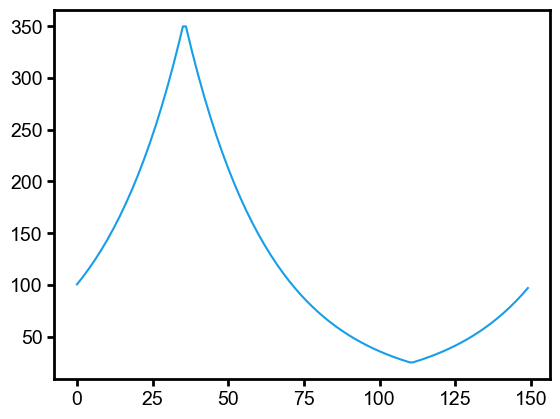

In [2]:
# GEnerate the noise sequence

num_frames=150

initial_noise_std=100
max_noise_std=350
min_noise_std=25

# Define key points for noise levels
noise_sequence = np.logspace(np.log10(min_noise_std), np.log10(max_noise_std), num_frames // 2)
noise_sequence = np.concatenate([noise_sequence, noise_sequence[::-1]])
# find the offset to the initial noise level
roll_offset = np.where(noise_sequence > initial_noise_std)[0][0]
noise_sequence = np.roll(noise_sequence, -int(roll_offset))
# plot noise sequence
fig, ax = plt.subplots()
ax.plot(noise_sequence)

100%|██████████| 150/150 [00:38<00:00,  3.88it/s]


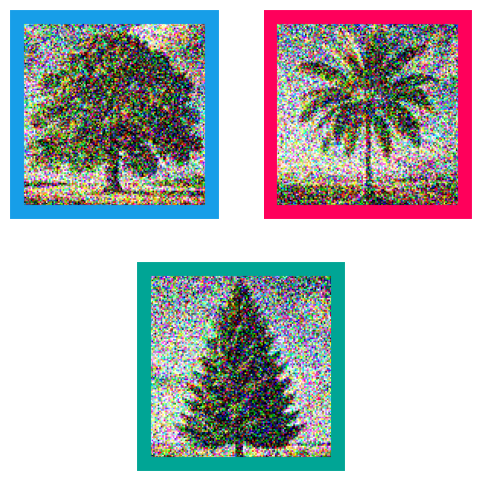

In [3]:
# shape = (220, 220)
shape = (128, 128)

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from scipy.stats import multivariate_normal
from encoding_information import add_noise
from cleanplots import *
from animations.annimations_utils import *
import matplotlib.gridspec as gridspec

# Colors of the borders around the images
colors = [get_color_cycle()[0], get_color_cycle()[2], '#00A595']

# gaussian_noise_sigma = np.logspace(0, 1.5, num_frames)
gaussian_noise_sigma = noise_sequence
name = 'noisy_encoder_comparison'

# Set up directories to save frames
def setup_frames_dir(directory_name):
    save_path = os.path.join('/home/your_username/figures/trees_changing_noise/', directory_name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # clear the directory
    for file in os.listdir(save_path):
        os.remove(os.path.join(save_path, file))
    return save_path

save_dir = '/home/your_username/figures/trees_changing_noise/'
save_path1 = setup_frames_dir(name)

# Load tree images
path = '/home/your_username/data/trees/'
image_names = ['tree1_clean.png', 'tree2_clean.png', 'tree3_clean.png']
images = []

for name in image_names:
    img = Image.open(os.path.join(path, name))
    img = img.resize(shape) 
    img = np.array(img)
    images.append(img)

# Ensure images are numpy arrays
images = [np.array(img) for img in images]


# generate the noisy images
for frame_num in tqdm(range(num_frames)):
    # Create a figure for noisy images
    fig = plt.figure(figsize=(6, 6))  # Adjust height to make space for 2 rows
    gs = gridspec.GridSpec(2, 2)

    # Two axes on the top row (left and right)
    ax1 = fig.add_subplot(gs[0, 0])  # Top left
    ax2 = fig.add_subplot(gs[0, 1])  # Top right

    # One centered axis on the bottom row (spanning both columns)
    ax3 = fig.add_subplot(gs[1, 0:2])  # Bottom, spanning both columns

    ax = [ax1, ax2, ax3]

    for j in range(len(images)):
        image = images[j]
        # Add Gaussian noise with changing sigma
        noisy_image = add_noise(image, gaussian_sigma=gaussian_noise_sigma[frame_num])

        # clip to 0 255
        noisy_image = np.clip(noisy_image, 0, 255) / 255

        # Display the noisy image with a colored border
        imshow_with_border(ax[j], noisy_image, colors[j])
        ax[j].axis('off')  # Hide axes for cleaner visualization

    # Save the figure containing noisy images
    fig.savefig(f"{save_path1}/image_{frame_num:04d}.png", dpi=300, bbox_inches='tight')
    if frame_num != 0:
        plt.close(fig)

In [4]:
!rm /home/your_username/figures/trees_changing_noise/noisy_encoder_comparison.mp4
!ffmpeg -y -framerate 30 -i /home/your_username/figures/trees_changing_noise/noisy_encoder_comparison/image_%04d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/your_username/figures/trees_changing_noise/3_images_changing_noise.mp4

rm: cannot remove '/home/your_username/figures/trees_changing_noise/noisy_encoder_comparison.mp4': No such file or directory
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enabl

In [16]:
from matplotlib.colors import LinearSegmentedColormap

cmaps = [LinearSegmentedColormap.from_list(f'cmap_magenta', [(1,1,1), get_color_cycle()[0]]),
        LinearSegmentedColormap.from_list(f'cmap_magenta', [(1,1,1), get_color_cycle()[2]]),
        LinearSegmentedColormap.from_list(f'cmap_magenta', [(1,1,1), '#00A595'])]


name2 = 'noisy_encoder_comparison_density'
save_path2 = setup_frames_dir(name2)

num_frames = 150


# Define min and max sigma values
max_sigma = 0.01
min_sigma = 1e-5

# Calculate the logarithmic positions from the previous cell
log_min_noise_std = np.log10(min_noise_std)
log_max_noise_std = np.log10(max_noise_std)
log_initial_noise_std = np.log10(initial_noise_std)
proportion = (log_initial_noise_std - log_min_noise_std) / (log_max_noise_std - log_min_noise_std)

# Compute the corresponding initial_sigma
log_min_sigma = np.log10(min_sigma)
log_max_sigma = np.log10(max_sigma)
log_initial_sigma = log_min_sigma + proportion * (log_max_sigma - log_min_sigma)
initial_sigma = 10 ** log_initial_sigma

# Generate the sigma sequence
half_frames = num_frames // 2
display_sigma = np.logspace(log_min_sigma, log_max_sigma, half_frames)
display_sigma = np.concatenate([display_sigma, display_sigma[::-1]])

# Roll the sequence to start at initial_sigma
roll_offset = np.where(display_sigma > initial_sigma)[0][0]
display_sigma = np.roll(display_sigma, -int(roll_offset))



# Define point centers for density plots
point_centers = np.array([[0.576, 0.475],
                            [0.42, 0.4345],
                          [0.51, 0.58],])
point_centers =  (point_centers + 0.5) / 2

# Blend the densities for the three points
for frame_num in tqdm(range(num_frames)):
    # Create a figure for density plots
    fig, ax_density = plt.subplots(1, 1, figsize=(3, 3))

    # Generate a 2D Gaussian density plot
    cov = np.eye(2) * display_sigma[frame_num]
    densities = []
    x = np.linspace(0, 1, 300)
    y = np.linspace(0, 1, 300)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    for mu in point_centers:
        prob = multivariate_normal.pdf(pos, mu, cov)
        prob /= np.max(prob)
        densities.append(prob)

    # Blend densities using the specified colormaps
    blended_color = np.prod(np.stack([cmap(hist) for cmap, hist in 
                                        zip(cmaps, densities)], axis=0), axis=0)

    # Display the density plot
    ax_density.imshow(blended_color, origin='lower')
    clear_spines(ax_density)
    ax_density.set(xticks=[], yticks=[])

    # Save the figure containing the density plot
    fig.savefig(f"{save_path2}/image_{frame_num:04d}.png", dpi=300, bbox_inches='tight')
    # break
    plt.close(fig)
    
!rm /home/your_username/figures/trees_changing_noise/noisy_encoder_comparison_density.mp4
!ffmpeg -y -framerate 30 -i /home/your_username/figures/trees_changing_noise/noisy_encoder_comparison_density/image_%04d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/your_username/figures/trees_changing_noise/noisy_encoder_comparison_density.mp4

100%|██████████| 150/150 [00:20<00:00,  7.30it/s]


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

# Compare 2 with hi-res noisy vs low-res less noisy

In [57]:
from PIL import Image
from encoding_information import add_noise

shape = (220, 220)
sigma = 200

# load tree1 high res
tree1 = Image.open('/home/your_username/data/trees/cropped_for_alignment/tree1.png')
tree1 = np.array(tree1)

tree2 = Image.open('/home/your_username/data/trees/cropped_for_alignment/tree2.png')
tree2 = np.array(tree2)

# resize
tree1 = np.array(Image.fromarray(tree1).resize(shape)).astype(np.float32)
tree2 = np.array(Image.fromarray(tree2).resize(shape)).astype(np.float32)

# make 30 noisy versions
noisy_tree1 = np.array([add_noise(tree1, gaussian_sigma=sigma) for _ in range(30)])
noisy_tree2 = np.array([add_noise(tree2, gaussian_sigma=sigma) for _ in range(30)])
noisy_tree1 = np.clip(noisy_tree1, 0, 255) / 255
noisy_tree2 = np.clip(noisy_tree2, 0, 255) / 255

# save to uncompressed pngs
for i, img in enumerate(noisy_tree1):
    img = Image.fromarray((img * 255).astype(np.uint8))
    img.save(f'/home/your_username/data/trees/res_noise_comparison/hrhn1/{i}.png')

for i, img in enumerate(noisy_tree2):
    img = Image.fromarray((img * 255).astype(np.uint8))
    img.save(f'/home/your_username/data/trees/res_noise_comparison/hrhn2/{i}.png')

# save the original hi res
img = Image.fromarray((tree1).astype(np.uint8))
img.save(f'/home/your_username/data/trees/res_noise_comparison/hi_res_clean_tree1.png')

img = Image.fromarray((tree2).astype(np.uint8))
img.save(f'/home/your_username/data/trees/res_noise_comparison/hi_res_clean_tree2.png')



In [58]:
!rm /home/your_username/data/trees/res_noise_comparison/hrhn1.mp4
!ffmpeg -y -framerate 30 -i /home/your_username/data/trees/res_noise_comparison/hrhn1/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/your_username/data/trees/res_noise_comparison/hrhn1.mp4

!rm /home/your_username/data/trees/res_noise_comparison/hrhn2.mp4
!ffmpeg -y -framerate 30 -i /home/your_username/data/trees/res_noise_comparison/hrhn2/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/your_username/data/trees/res_noise_comparison/hrhn2.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [59]:
from scipy.ndimage import gaussian_filter

blur_sigma = 6
noise_sigma = 10


# Function to apply Gaussian blur to each channel
def blur_each_channel(image, sigma):
    blurred_image = np.zeros_like(image)
    for channel in range(3):  # Assuming the input is an RGB image
        blurred_image[:, :, channel] = gaussian_filter(image[:, :, channel], sigma=sigma, mode='reflect')
    return blurred_image

# Apply Gaussian blur to each channel independently
blurred_tree1 = blur_each_channel(tree1, blur_sigma)
blurred_tree2 = blur_each_channel(tree2, blur_sigma)

# # Normalize the blurred images to the range [0, 1]
# blurred_tree1 = np.clip(blurred_tree1 / 255, 0, 1)
# blurred_tree2 = np.clip(blurred_tree2 / 255, 0, 1)

# # plot 
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# axs[0].imshow(blurred_tree1)
# axs[0].axis('off')
# axs[1].imshow(blurred_tree2)
# axs[1].axis('off')

# make 30 noisy versions
noisy_tree1 = np.array([add_noise(blurred_tree1, gaussian_sigma=noise_sigma) for _ in range(30)])
noisy_tree2 = np.array([add_noise(blurred_tree2, gaussian_sigma=noise_sigma) for _ in range(30)])
noisy_tree1 = np.clip(noisy_tree1, 0, 255) / 255
noisy_tree2 = np.clip(noisy_tree2, 0, 255) / 255

# save to uncompressed pngs
for i, img in enumerate(noisy_tree1):
    img = Image.fromarray((img * 255).astype(np.uint8))
    img.save(f'/home/your_username/data/trees/res_noise_comparison/lrln1/{i}.png')

for i, img in enumerate(noisy_tree2):
    img = Image.fromarray((img * 255).astype(np.uint8))
    img.save(f'/home/your_username/data/trees/res_noise_comparison/lrln2/{i}.png')

# save the clean blurry images
img = Image.fromarray((blurred_tree1).astype(np.uint8))
img.save(f'/home/your_username/data/trees/res_noise_comparison/blurry_tree1.png')

img = Image.fromarray((blurred_tree2).astype(np.uint8))
img.save(f'/home/your_username/data/trees/res_noise_comparison/blurry_tree2.png')

In [60]:
!rm /home/your_username/data/trees/res_noise_comparison/lrln1.mp4
!ffmpeg -y -framerate 30 -i /home/your_username/data/trees/res_noise_comparison/lrln1/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/your_username/data/trees/res_noise_comparison/lrln1.mp4

!rm /home/your_username/data/trees/res_noise_comparison/lrln2.mp4
!ffmpeg -y -framerate 30 -i /home/your_username/data/trees/res_noise_comparison/lrln2/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/your_username/data/trees/res_noise_comparison/lrln2.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

# Meaurement and noise distributions

In [1]:
# make a movie of the files in trees/low_res_noisy_(220, 220)_75
# animating at 15 fps

!rm /home/your_username/data/trees/low_res_noisy_\(220\,\ 220\)_75.mp4
!ffmpeg -y -framerate 15 -i /home/your_username/data/trees/low_res_noisy_\(220\,\ 220\)_75/noisy_%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/your_username/data/trees/low_res_noisy_\(220\,\ 220\)_75.mp4

rm: cannot remove '/home/your_username/data/trees/low_res_noisy_(220, 220)_75.mp4': No such file or directory
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --ena

In [7]:
# make 30 frames of noise at 220 x 220 75 sigma
import numpy as np
from PIL import Image
import os

shape = (220, 220, 3)
sigma = 75

frames = np.random.randn(30, *shape) * sigma + 0.5
# clip to 0 1
frames = np.clip(frames, 0, 1)

# make the folder

if not os.path.exists('/home/your_username/data/trees/noise_frames'):
    os.makedirs('/home/your_username/data/trees/noise_frames')

# save to uncompressed pngs
for i, img in enumerate(frames):
    img = Image.fromarray((img * 255).astype(np.uint8))
    img.save(f'/home/your_username/data/trees/noise_frames/{i}.png')

!ffmpeg -y -framerate 30 -i /home/your_username/data/trees/noise_frames/%d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p /home/your_username/data/trees/noise_frames/noise.mp4


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

# Dim noisy tree

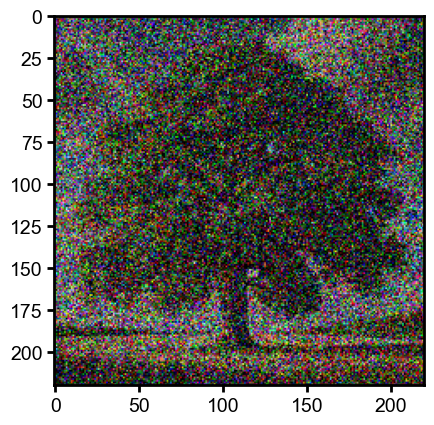

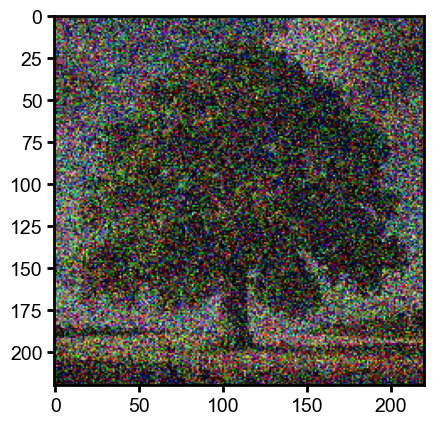

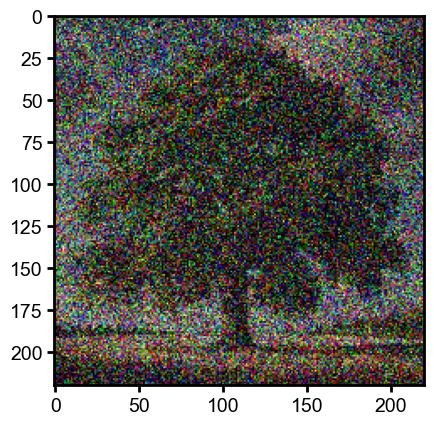

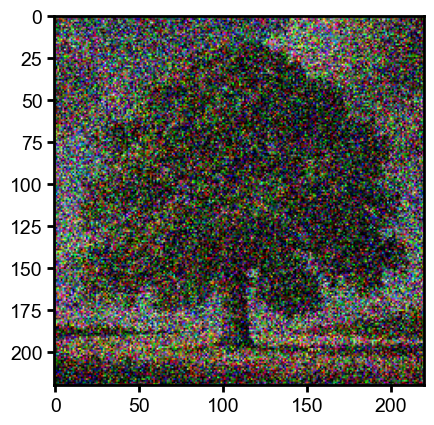

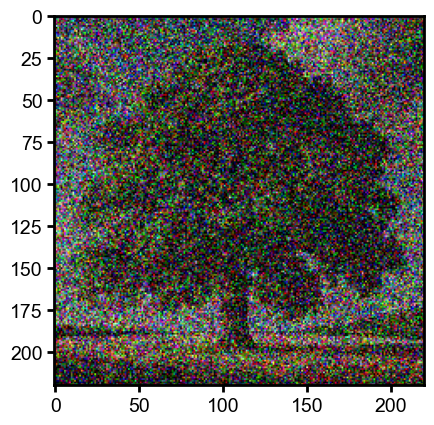

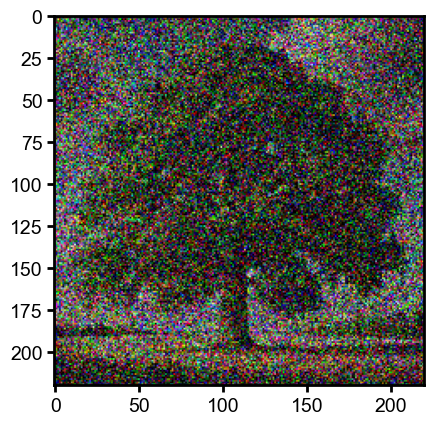

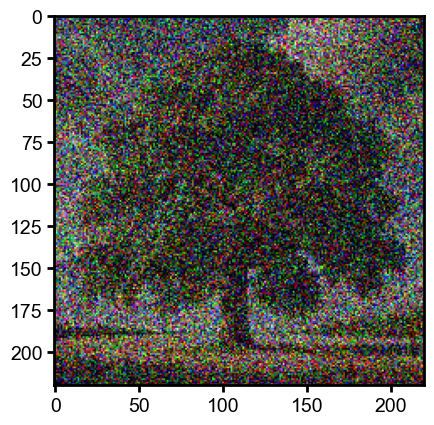

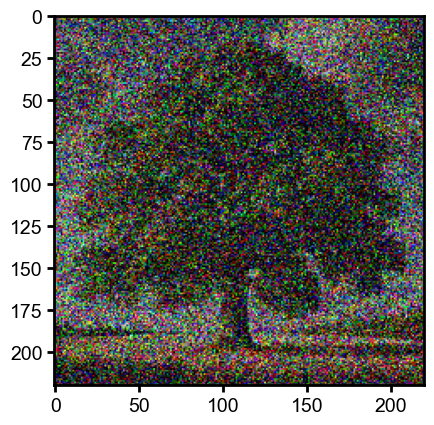

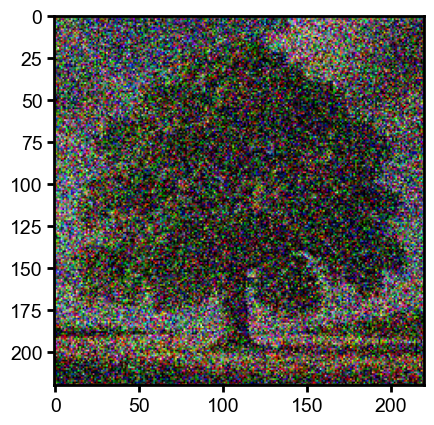

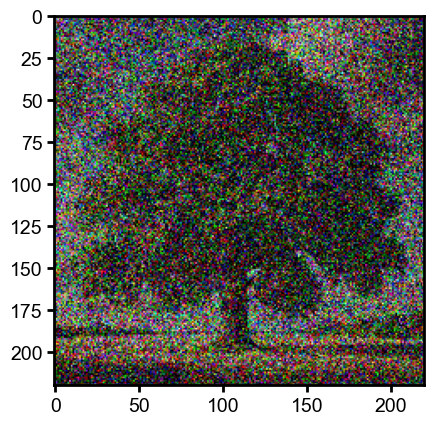

In [7]:
# make a 220 x 220 dim, noisy tree

from PIL import Image
import numpy as np
import os
from encoding_information import add_noise

shape = (220, 220)
sigma = 75
brightness = 0.5

# load tree1 high res
tree1 = Image.open('/home/your_username/data/trees/high_res/tree1.png')
tree1 = np.array(tree1)

# resize
tree1 = np.array(Image.fromarray(tree1).resize(shape))

tree1 = brightness * tree1.astype(float)

for i in range(10):
    # add noise
    noisy_tree1 = add_noise(tree1, gaussian_sigma=sigma)

    # clip to 0 255
    noisy_tree1 = np.clip(noisy_tree1, 0, 255) / 255

    # plot
    fig, ax = plt.subplots()
    ax.imshow(noisy_tree1)

    # save the image as a png
    img = Image.fromarray((np.array(noisy_tree1) * 255).astype(np.uint8))
    img.save(f'/home/your_username/data/trees/smartphone_burst_tree/{i}.png')



# Make cover animation

In [1]:
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Assuming add_noise function is defined as follows:
def add_noise(image, gaussian_sigma):
    noise = np.random.normal(0, gaussian_sigma, image.shape)
    noisy_image = image + noise
    return noisy_image

# Load tree images
shape = (220, 220)
# open all trees in /home/your_username/data/trees/high_res
trees = []
for name in os.listdir('/home/your_username/data/trees/high_res'):
    img = Image.open(f'/home/your_username/data/trees/high_res/{name}')
    img = img.resize(shape)
    img = np.array(img)
    trees.append(img)

# Parameters
grid_size = (8, 8)  # Grid size (rows, columns)
num_frames = 300     # Total number of frames in the animation
noise_period = 300          # Period of the sinusoidal functions
blur_period = 100          # Period of the sinusoidal functions

# Blur and noise parameters
min_blur = 0
max_blur = 15
min_noise = 0
max_noise = 150

# Output directory
output_dir = '/home/your_username/data/trees/animation_frames'
os.makedirs(output_dir, exist_ok=True)
# clear the directory
for file in os.listdir(output_dir):
    os.remove(os.path.join(output_dir, file))

# Function to apply Gaussian blur to each channel
def blur_each_channel(image, sigma):
    blurred_image = np.zeros_like(image)
    for channel in range(3):  # Assuming RGB image
        blurred_image[:, :, channel] = gaussian_filter(image[:, :, channel], sigma=sigma, mode='reflect')
    return blurred_image

# Generate frames
for t in tqdm(range(num_frames)):
    # Initialize a list to hold the images for this frame
    row_images = []
    for y in range(grid_size[0]):  # Rows
        col_images = []
        for x in range(grid_size[1]):  # Columns
            # Compute blur and noise levels
            blur_phase = 2 * np.pi * y / grid_size[0]
            noise_phase = 2 * np.pi * x / grid_size[1]
            blur_sigma = min_blur + (max_blur - min_blur) * (np.sin(2 * np.pi * t / blur_period + blur_phase) + 1) / 2
            noise_sigma = min_noise + (max_noise - min_noise) * (np.sin(2 * np.pi * t / noise_period + noise_phase) + 1) / 2

            # pick a random tree
            np.random.seed(x + y)
            img = trees[np.random.randint(len(trees))]
            np.random.seed(None)

            # Apply blur and noise
            blurred_img = blur_each_channel(img, blur_sigma)
            noisy_img = add_noise(blurred_img, gaussian_sigma=noise_sigma)
            noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
            col_images.append(Image.fromarray(noisy_img))

        # Concatenate images horizontally
        row_image = np.hstack([np.array(img) for img in col_images])
        row_images.append(row_image)

    # Concatenate images vertically to form the grid
    frame_image = np.vstack(row_images)
    # resize and crop to full HD
    # first crop to 16:9 aspect ratio
    h, w = frame_image.shape[:2]
    # crop the height
    diff = h - w * 9 / 16
    frame_image = frame_image[:h - int(diff), :]
    frame_image = Image.fromarray(frame_image)
    frame_image = frame_image.resize((1920, 1080))
    frame_image.save(os.path.join(output_dir, f'frame_{t:03d}.png'))

# Create video using ffmpeg
video_output_path = '/home/your_username/data/trees/animation.mp4'
os.system(f'ffmpeg -y -framerate 20 -i {output_dir}/frame_%03d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 23 -pix_fmt yuv420p {video_output_path}')


100%|██████████| 300/300 [04:51<00:00,  1.03it/s]
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-lib

0

In [2]:
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
import os

# Function to add Gaussian noise to an image
def add_noise(image, gaussian_sigma):
    noise = np.random.normal(0, gaussian_sigma, image.shape)
    noisy_image = image + noise
    return noisy_image

# Function to apply Gaussian blur to each channel of an image
def blur_each_channel(image, sigma):
    blurred_image = np.zeros_like(image)
    for channel in range(3):  # Assuming RGB image
        blurred_image[:, :, channel] = gaussian_filter(
            image[:, :, channel], sigma=sigma, mode='reflect'
        )
    return blurred_image

# Parameters
shape = (220, 220)  # Resize shape for each tree image
grid_size = (8, 8)  # Grid size (rows, columns)
min_blur = 0        # Minimum blur level
max_blur = 13      # Maximum blur level
min_noise = 0       # Minimum noise level
max_noise = 120     # Maximum noise level

# Directories (update these paths as needed)
tree_dir = '/home/your_username/data/trees/high_res'
output_path = '/home/your_username/data/trees/montage.png'

# Load tree images
trees = []
for name in os.listdir(tree_dir):
    img_path = os.path.join(tree_dir, name)
    img = Image.open(img_path).resize(shape)
    trees.append(np.array(img))

# Generate the montage image
row_images = []
for y in range(grid_size[0]):  # Rows
    col_images = []
    for x in range(grid_size[1]):  # Columns
        # Generate random blur and noise levels within limits
        blur_sigma = np.random.uniform(min_blur, max_blur)
        noise_sigma = np.random.uniform(min_noise, max_noise)

        # Pick a random tree image
        img = trees[np.random.randint(len(trees))]

        # Apply blur and noise
        blurred_img = blur_each_channel(img, blur_sigma)
        noisy_img = add_noise(blurred_img, gaussian_sigma=noise_sigma)
        noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
        col_images.append(noisy_img)

    # Concatenate images horizontally
    row_image = np.hstack(col_images)
    row_images.append(row_image)

# Concatenate images vertically to form the grid
montage_image = np.vstack(row_images)

# Crop to 16:9 aspect ratio and resize to 1920x1080
h, w = montage_image.shape[:2]
target_aspect_ratio = 16 / 9
current_aspect_ratio = w / h

if current_aspect_ratio > target_aspect_ratio:
    # Crop width
    new_w = int(h * target_aspect_ratio)
    start_w = (w - new_w) // 2
    montage_image = montage_image[:, start_w:start_w + new_w]
elif current_aspect_ratio < target_aspect_ratio:
    # Crop height
    new_h = int(w / target_aspect_ratio)
    start_h = (h - new_h) // 2
    montage_image = montage_image[start_h:start_h + new_h, :]

montage_image = Image.fromarray(montage_image)
montage_image = montage_image.resize((1920, 1080), Image.ANTIALIAS)

# Save the final montage image
montage_image.save(output_path)


/tmp/ipykernel_216680/1253613364.py:82: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  montage_image = montage_image.resize((1920, 1080), Image.ANTIALIAS)
